In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("..")

import os
os.environ['D4RL_SUPPRESS_IMPORT_ERROR'] = '1'

import gym
import d4rl

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from matplotlib import patches

import equinox as eqx
import jax
import jax.numpy as jnp
import functools

pybullet build time: May 20 2022 19:45:31


In [2]:
@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None))
def eval_ensemble_psi(ensemble, s):
    return eqx.filter_vmap(ensemble.psi_net)(s)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None))
def eval_ensemble_phi(ensemble, s):
    return eqx.filter_vmap(ensemble.phi_net)(s)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None))
def eval_ensemble_icvf_viz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf_initial)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None)) # V(s, g, z), g - dim 29, z - dim 256
def eval_ensemble_icvf_latent_z(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None)) # V(s, g ,z ), g, z - dim 256
def eval_ensemble_icvf_latent_zz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.icvf_zz)(s, g, z)

@eqx.filter_jit
def get_gcvalue(agent, s, g, z):
    v_sgz_1, v_sgz_2 = eval_ensemble_icvf_viz(agent.value_learner.model, s, g, z)
    return (v_sgz_1 + v_sgz_2) / 2

def get_v_gz(agent, initial_state, target_goal, observations):
    initial_state = jnp.tile(initial_state, (observations.shape[0], 1))
    target_goal = jnp.tile(target_goal, (observations.shape[0], 1))
    return -1 * get_gcvalue(agent, initial_state, observations, target_goal)
    
def get_v_zz(agent, goal, observations):
    goal = jnp.tile(goal, (observations.shape[0], 1))
    return get_gcvalue(agent, observations, goal, goal)

@eqx.filter_vmap(in_axes=dict(agent=None, obs=None, goal=0))
def get_v_zz_heatmap(agent, obs, goal): # goal - whole traj
    goal = jnp.tile(goal, (obs.shape[0], 1))
    return get_gcvalue(agent, obs, goal, goal)

In [3]:
def generate_maze_img(ax, fig, n=50, icvf_values="not", state_list=None):
    torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
    S =  env.env.env._wrapped_env._maze_size_scaling
    points = XY(env, n=n)
    if state_list is None:
        whole_grid = d4rl_ds['observations'][-1]
    else:
        whole_grid = state_list[-5]
    whole_grid = np.tile(whole_grid, (points.shape[0], 1))
    whole_grid[:, :2] = points
    
    if icvf_values is None:
        Z = np.random.rand(n, n)
    else:
        Z = get_v_zz_heatmap(icvf_model, whole_grid, state_list).mean(0)
    im = ax.pcolormesh(points[:,0].reshape(n, n), points[:, 1].reshape(n, n), Z.reshape(n, n), edgecolor='black', shading='nearest')
    
    for i in range(len(env.env.env._wrapped_env._maze_map)):
        for j in range(len(env.env.env._wrapped_env._maze_map[0])):
            struct = env.env.env._wrapped_env._maze_map[i][j]
            if struct == 1:
                rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                        i * S- torso_y - S/ 2),
                                        S,
                                        S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
                ax.add_patch(rect)
    ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env._wrapped_env._maze_map[0]) * S - torso_x - S/2 - S * 0.6)
    ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env._wrapped_env._maze_map) * S - torso_y - S/2 - S * 0.6)
    fig.colorbar(im)
    return ax

def get_starting_boundary(env):
    torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
    maze_map = env.env.env._wrapped_env._maze_map
    S = env.env.env._wrapped_env._maze_size_scaling
    return (0 - S / 2 + S - torso_x, 0 - S/2 + S - torso_y), (len(maze_map[0]) * S - torso_x - S/2 - S, len(maze_map) * S - torso_y - S/2 - S)

def XY(env, n=10):
    bl, tr = get_starting_boundary(env)
    X = np.linspace(bl[0] + 0.04 * (tr[0] - bl[0]) , tr[0] - 0.04 * (tr[0] - bl[0]), n)
    Y = np.linspace(bl[1] + 0.04 * (tr[1] - bl[1]) , tr[1] - 0.04 * (tr[1] - bl[1]), n)
    
    X,Y = np.meshgrid(X,Y)
    states = np.array([X.flatten(), Y.flatten()]).T
    return states

## ICVF pretrained on Antmaze-umaze-diverse-v2

In [4]:
env = gym.make("antmaze-umaze-v2")
d4rl_ds = d4rl.qlearning_dataset(env)
dones_float = np.zeros_like(d4rl_ds['rewards'])

for i in range(len(dones_float) - 1):
    if np.linalg.norm(d4rl_ds['observations'][i + 1] - d4rl_ds['next_observations'][i]) > 1e-6 or d4rl_ds['terminals'][i] == 1.0:
        dones_float[i] = 1
    else:
        dones_float[i] = 0
dones_float[-1] = 1
d4rl_ds['dones_float'] = dones_float

Target Goal:  (0.728296493747312, 8.334999298437085)


load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.23it/s]


In [9]:
%cd ..
from src.agents import icvf
icvf_model = icvf.create_eqx_learner(seed=42,
                                     observations=d4rl_ds['observations'][0],
                                     hidden_dims=[256, 256],
                                     pretrained_folder="antmaze-large-diverse",
                                     load_pretrained_icvf=True)


/home/nazar/PycharmProjects/AILOT


Extra kwargs: {'pretrained_folder': 'antmaze-large-diverse'}


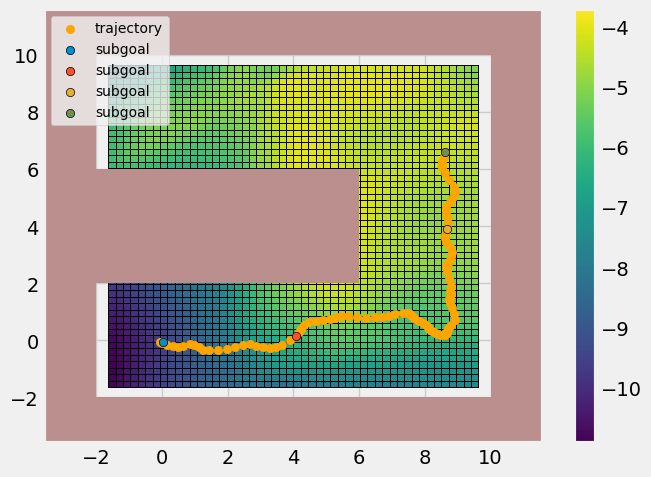

In [6]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(7, 5))
state_list = d4rl_ds['observations'][np.arange(start=3500, stop=3600)]
SUBGOALS = state_list[[0, 25, 85, 99]]
generate_maze_img(ax, fig, state_list=state_list)

plt.scatter(state_list[:, 0], state_list[:, 1], alpha=1, label='trajectory', color='orange')
for i in range(SUBGOALS.shape[0]):
    plt.scatter(*SUBGOALS[i, :2], label="subgoal", edgecolors='black', alpha=1)
    
plt.legend(loc='upper left', fontsize=10)
fig.tight_layout()


In [7]:
import jax.numpy as jnp

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None))
def eval_ensemble_icvf_viz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf_initial)(s, g, z)

base_observation = jnp.tile(SUBGOALS[-1, :], (state_list.shape[0], 1))
eval_ensemble_icvf_viz(icvf_model.value_learner.model, state_list, base_observation, base_observation).mean(0)

Array([-10.794963  ,  -9.420346  ,  -8.468478  ,  -8.781195  ,
        -8.841913  ,  -9.003918  ,  -8.4215    ,  -8.097468  ,
        -8.149333  ,  -7.567953  ,  -7.9770794 ,  -8.841177  ,
        -8.471791  ,  -8.428262  ,  -7.227848  ,  -6.4803042 ,
        -7.0942173 ,  -6.782666  ,  -8.3670225 ,  -8.632784  ,
        -8.633065  ,  -8.173199  ,  -7.2226787 ,  -7.4717903 ,
        -6.8152122 ,  -6.160347  ,  -6.2600026 ,  -6.5340137 ,
        -6.251856  ,  -6.73351   ,  -6.6570315 ,  -6.746784  ,
        -7.0805836 ,  -7.3962736 ,  -7.422643  ,  -6.736514  ,
        -6.8053575 ,  -7.0585465 ,  -6.638567  ,  -6.95018   ,
        -6.9502296 ,  -6.696879  ,  -7.16856   ,  -7.0913777 ,
        -7.149267  ,  -6.8525324 ,  -6.955645  ,  -6.488896  ,
        -6.8555307 ,  -6.894894  ,  -6.897341  ,  -7.0408707 ,
        -7.215147  ,  -7.341092  ,  -7.190255  ,  -7.7071395 ,
        -7.902267  ,  -6.9402084 ,  -7.2789145 ,  -6.6282187 ,
        -6.7902594 ,  -6.390601  ,  -5.990594  ,  -6.14

### Antmaze-Large-diverse

In [3]:
env = gym.make("antmaze-large-diverse-v2")
d4rl_ds = d4rl.qlearning_dataset(env)
dones_float = np.zeros_like(d4rl_ds['rewards'])
for i in range(len(dones_float) - 1):
    if np.linalg.norm(d4rl_ds['observations'][i + 1] - d4rl_ds['next_observations'][i]) > 1e-6 or d4rl_ds['terminals'][i] == 1.0:
        dones_float[i] = 1
    else:
        dones_float[i] = 0
dones_float[-1] = 1
d4rl_ds['dones_float'] = dones_float

Target Goal:  (32.429806090004114, 25.007484444722483)


load datafile:   0%|          | 0/8 [00:00<?, ?it/s]

load datafile: 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]


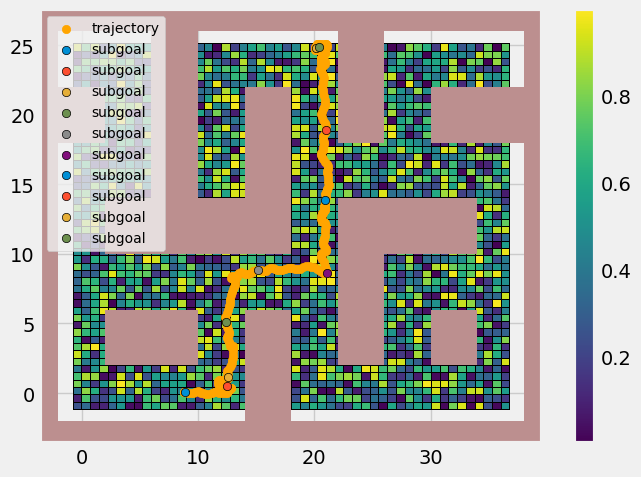

In [9]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 5))
generate_maze_img(ax, fig, icvf_values=None)

state_list = d4rl_ds['observations'][np.arange(start=90000, stop=90500)]
SUBGOALS = state_list[[0, 30, 50, 80, 115, 145, 190, 220, 260, 299]]
plt.scatter(state_list[:, 0], state_list[:, 1], alpha=1, label='trajectory', color='orange')
for i in range(SUBGOALS.shape[0]):
    plt.scatter(*SUBGOALS[i, :2], label="subgoal", edgecolors='black', alpha=1)
    
plt.legend(loc='upper left', fontsize=10)
fig.tight_layout()


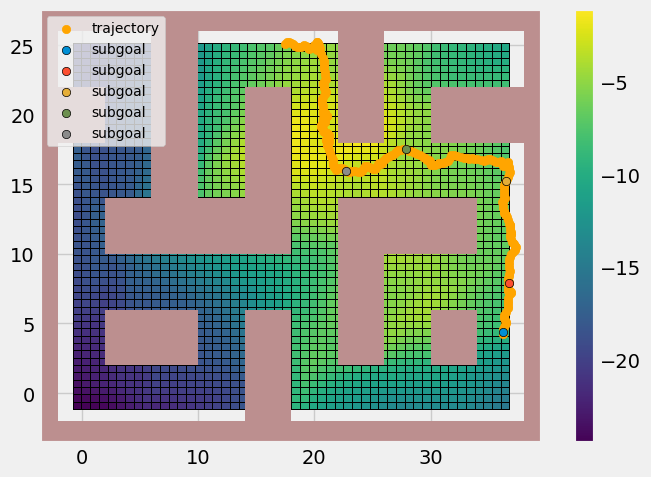

In [10]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(7, 5))

state_list = d4rl_ds['observations'][np.arange(start=1000, stop=1350)]
generate_maze_img(ax, fig, state_list=state_list)

SUBGOALS = state_list[[0, 30, 85, 150, 189]]
plt.scatter(state_list[:, 0], state_list[:, 1], alpha=1, label='trajectory', color='orange')
for i in range(SUBGOALS.shape[0]):
    plt.scatter(*SUBGOALS[i, :2], label="subgoal", edgecolors='black', alpha=1)
    
plt.legend(loc='upper left', fontsize=10)
fig.tight_layout()


In [11]:
state_list = d4rl_ds['observations'][np.arange(start=10000, stop=10190)]
SUBGOALS = state_list[[0, 30, 85, 150, 189]]
base_observation = jnp.tile(SUBGOALS[-1, :], (state_list.shape[0], 1))
eval_ensemble_icvf_viz(icvf_model.value_learner.model, state_list, base_observation, base_observation).mean(0)

Array([-17.478256  , -17.30465   , -16.869465  , -17.08562   ,
       -17.106853  , -16.749825  , -15.932642  , -15.784133  ,
       -15.869335  , -16.137762  , -15.722016  , -16.013878  ,
       -14.963801  , -14.449097  , -15.1678505 , -14.533704  ,
       -14.031532  , -13.504276  , -13.535313  , -14.106272  ,
       -15.404299  , -15.228119  , -13.764406  , -13.973988  ,
       -14.876314  , -14.493058  , -14.62711   , -13.719923  ,
       -12.861698  , -13.276011  , -14.17146   , -14.835335  ,
       -14.86113   , -14.572462  , -13.621906  , -13.432923  ,
       -14.815858  , -14.251545  , -14.195176  , -15.89215   ,
       -15.528644  , -14.355104  , -13.732457  , -14.0825    ,
       -14.013701  , -13.615461  , -12.944752  , -12.640871  ,
       -11.762817  , -12.773877  , -14.242939  , -14.14267   ,
       -13.273567  , -14.575469  , -13.660196  , -13.204073  ,
       -12.959467  , -12.67205   , -12.591806  , -12.412264  ,
       -11.785583  , -11.297546  , -11.052043  , -12.13

In [12]:
for sg in SUBGOALS:
    sg_repr = np.linalg.norm(eval_ensemble_psi(icvf_model.value_learner.model, sg[None]) - eval_ensemble_psi(icvf_model.value_learner.model, SUBGOALS[-1][None]))
    sg_value = get_v_zz(icvf_model, sg[None], SUBGOALS[-1, :][None])
    print(f"Value: {sg_value}", f"Norm: {sg_repr}")

Value: [-29.196423] Norm: 15.406472206115723
Value: [-16.59612] Norm: 15.315889358520508
Value: [-0.4990456] Norm: 14.732231140136719
Value: [-0.07210147] Norm: 11.71440315246582
Value: [5.7540736] Norm: 0.0


[0, 5, 36, 37, 59, 60, 73, 104, 107, 108, 121, 123, 176]


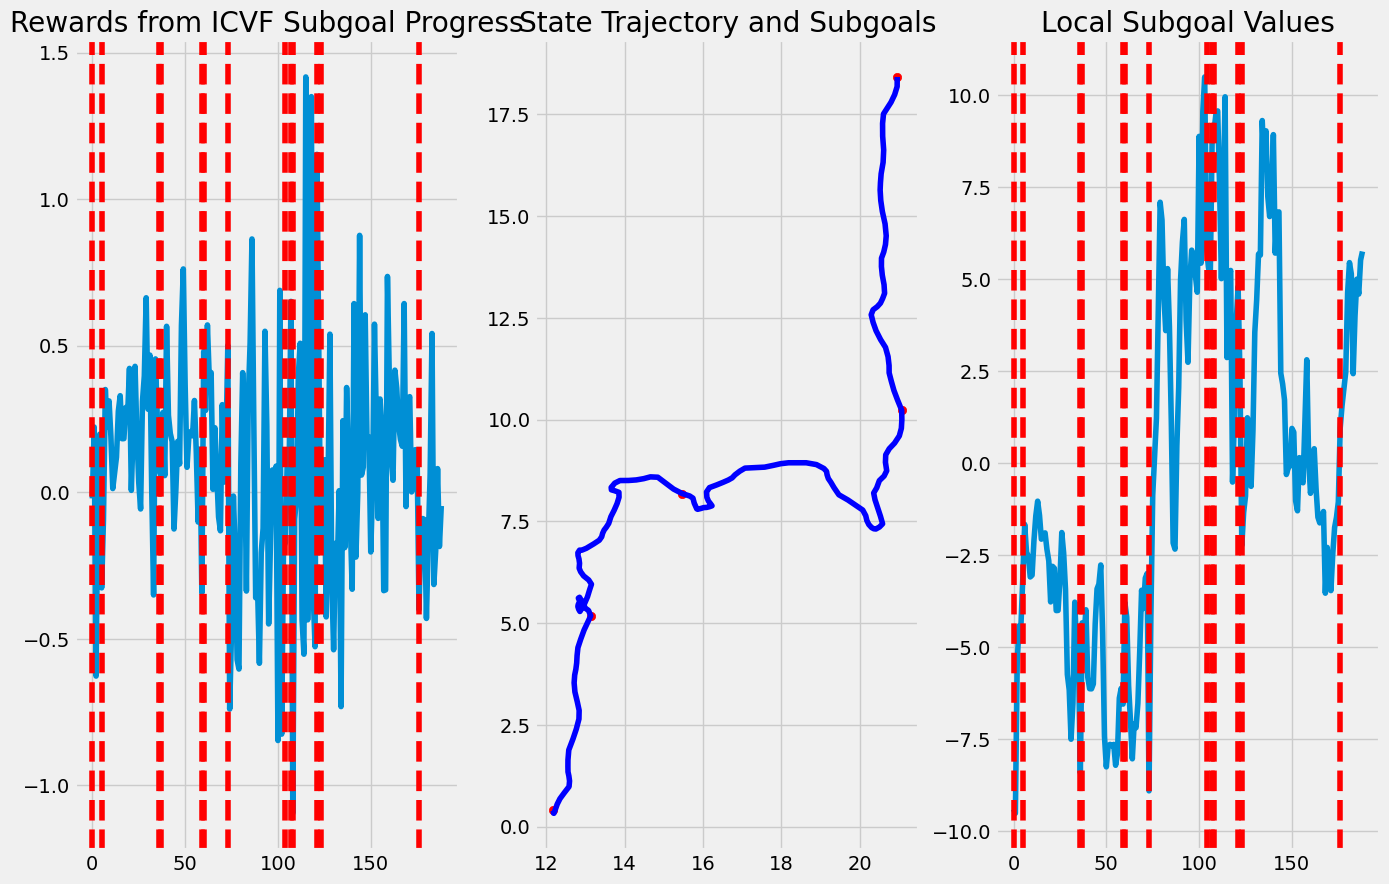

In [175]:
%matplotlib inline

rews = []
idx = 1
sg = SUBGOALS[idx]
eps = 0.5
subgoal_switches = []
vals = []

for i, state in enumerate(state_list[1:]):
    reward = 0
    old_idx = idx
    idx = np.argmax([get_v_zz(icvf_model, state[None], sg[None]) for sg in SUBGOALS])
    if old_idx != idx:
        subgoal_switches.append(i)
    sg = SUBGOALS[min(idx + 1, len(SUBGOALS) - 1)] # set next subgoal candidate
    
    if get_v_zz(icvf_model, state[None], sg[None]) <= eps:
        reward += 0.2

    val_to_sg = get_v_zz(icvf_model, state[None], sg[None]) # negative value
    vals.append(val_to_sg)
    last_val_to_sg = get_v_zz(icvf_model, state_list[i][None], sg[None]) # negative value
    val_diff = np.array(val_to_sg - last_val_to_sg).item()
    reward -= 0.2 * val_diff
    rews.append(reward)

print(subgoal_switches)
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].set_title('Rewards from ICVF Subgoal Progress')
axs[1].set_title('State Trajectory and Subgoals')
axs[2].set_title('Local Subgoal Values')
axs[0].plot(rews)

for i in subgoal_switches:
    axs[0].axvline(x=i, color='r', linestyle='--')
    
axs[1].plot(state_list[:, 0], state_list[:, 1], color='b')
axs[1].scatter(SUBGOALS[:, 0], SUBGOALS[:, 1], color='r')
axs[2].plot(vals)
for i in subgoal_switches:
    axs[2].axvline(x=i, color='r', linestyle='--')


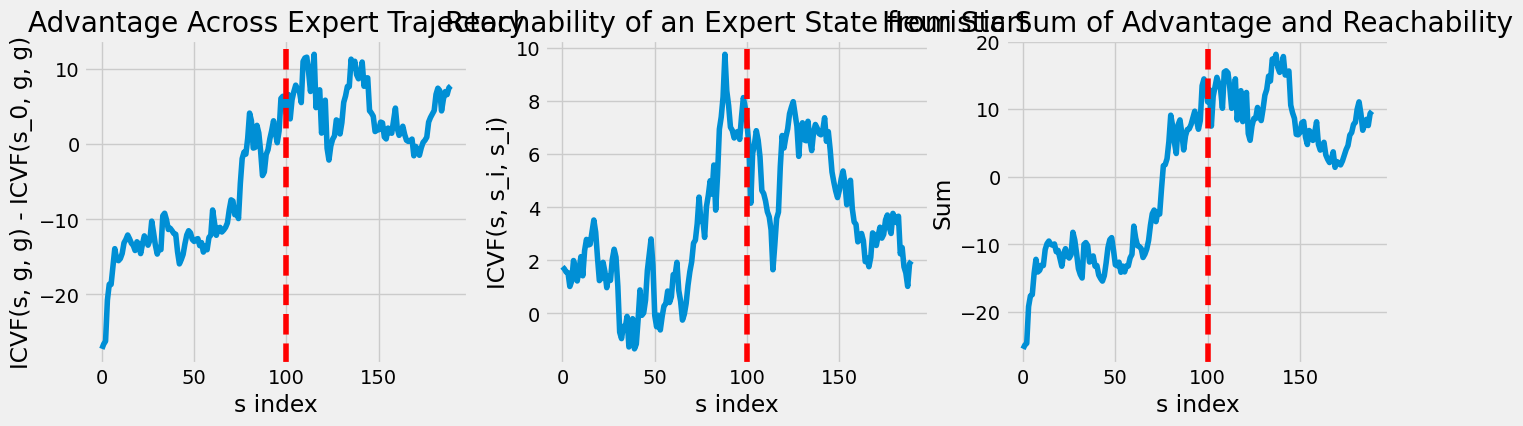

In [14]:
# loop through state list from beginning to end. 
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
START_IDX = 100
state_indxs = []
avds  = []
for i, state in enumerate(state_list):
    state_indxs.append(i)
    avds.append(get_v_zz(icvf_model, state[None], SUBGOALS[-1][None]) +  get_v_zz(icvf_model, state_list[START_IDX][None], SUBGOALS[-1][None]))

scale_adv = (np.array(avds) - avds[START_IDX]) / (avds[-1] - avds[START_IDX] + 1e-8)

axs[0].plot(state_indxs, avds)
axs[0].set_title('Advantage Across Expert Trajectory')
axs[0].set_ylabel('ICVF(s, g, g) - ICVF(s_0, g, g)')
axs[0].set_xlabel('s index')
axs[0].axvline(x=START_IDX, color='r', linestyle='--')

values  = []
for i, state in enumerate(state_list):
    values.append(get_v_zz(icvf_model, state_list[START_IDX][None], state[None]))

scale_values = (np.array(values) - values[START_IDX]) / (values[-1] - values[START_IDX] + 1e-8)

axs[1].plot(state_indxs, values)
axs[1].set_title('Reachability of an Expert State from Start')
axs[1].set_ylabel('ICVF(s, s_i, s_i)')
axs[1].set_xlabel('s index')
axs[1].axvline(x=START_IDX, color='r', linestyle='--')

a, b = 1, 1

def h_test(adv, val):
    scale_values = (np.array(val) - values[START_IDX]) / (values[-1] - values[START_IDX] + 1e-8)
    # scale_adv = (np.array(adv) - np.min(avds)) / (np.max(avds) - np.min(avds) + 1e-8)
    scale_adv = (np.array(adv) - avds[START_IDX]) / (avds[-1] - avds[START_IDX] + 1e-8)
    return a*scale_adv * b*(1 - scale_values)

heuristic  = [(a * adv) + (b * val) for adv, val in zip(avds, values)]
# heuristic = [h_test(adv, val) for adv, val in zip(avds, values)]
axs[2].plot(state_indxs, heuristic)
axs[2].set_title('Heuristic Sum of Advantage and Reachability')
axs[2].set_ylabel('Sum')
axs[2].set_xlabel('s index')
axs[2].axvline(x=START_IDX, color='r', linestyle='--')


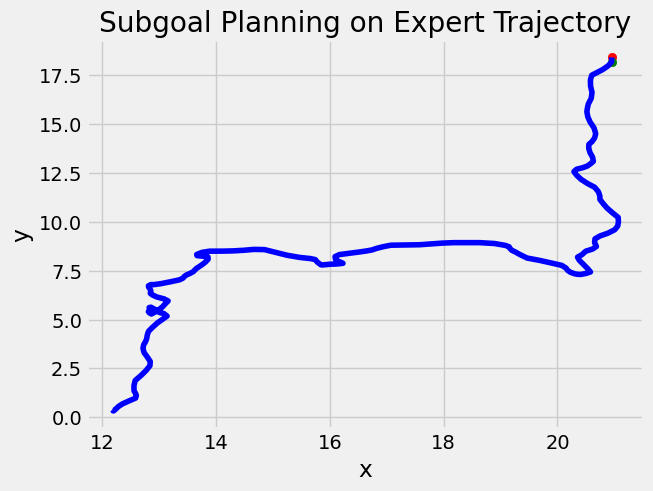

In [17]:
import matplotlib.animation as animation 

from IPython.display import HTML

a, b = 1, 1.1
state_indxs = []
fig, ax = plt.subplots()
ax.set_title('Subgoal Planning on Expert Trajectory')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(state_list[:, 0], state_list[:, 1], color='b')
scat = ax.scatter(state_list[0, 0], state_list[0, 1], color='r')
abc = None

def animate(i):
    global abc
    scat.set_offsets(state_list[i, :2])
    values  = []
    for j, state in enumerate(state_list[i+1:]):
        res = get_v_zz(icvf_model, state_list[i][None], state[None])
        values.append(res)
    avds = []
    for j, state in enumerate(state_list[i+1:]):
        state_indxs.append(j)
        value = get_v_zz(icvf_model, state[None], SUBGOALS[-1, :][None])
        avds.append(value + (-1) * get_v_zz(icvf_model, state_list[i][None], SUBGOALS[-1,:][None]))
    if len(state_list[i+1:]) !=0:
        max_idx = np.argmin(avds)
        if abc is not None:
            abc.set_visible(False)
        abc = ax.scatter(state_list[max_idx + i, 0], state_list[max_idx + i, 1], color='g')
    return scat,

anim = animation.FuncAnimation(fig, animate, frames=len(state_list), interval=200, blit=True)


HTML(anim.to_html5_video())


In [4]:
%matplotlib inline

scales_shifts = [(6, 40), (-6, 230)]
def scale_and_shift(x, lst):
    return lst[0] * x + lst[1]
    
def plot_traj_image(traj, start, goal, subgoals, bgpath):
    fig, ax = plt.subplots(figsize=(5, 5))
    pimage = plt.imread(bgpath)
    ax.imshow(pimage)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(scale_and_shift(expert_trajectory[:, 0], scales_shifts[0]), scale_and_shift(expert_trajectory[:, 1], scales_shifts[1]), alpha=1, label='trajectory', color='orange')
    ax.scatter(scale_and_shift(start[0], scales_shifts[0]), scale_and_shift(start[1], scales_shifts[1]), c='g', s=100, label='start')
    ax.scatter(scale_and_shift(goal[0], scales_shifts[0]), scale_and_shift(goal[1], scales_shifts[1]), c='r', s=100, label='goal')
    ax.scatter(scale_and_shift(subgoals[0], scales_shifts[0]), scale_and_shift(subgoals[1], scales_shifts[1]), c='b', s=100, label='S_{t+k}')
    ax.legend(fontsize=10)

def icvf_stat(batch):
    obs = batch["observations"]
    subgoal = batch["ailot_low_goals"]
    goal = batch["ailot_high_goals"]
    advantages = get_v_zz(icvf_model, goal, subgoal) - get_v_zz(icvf_model, goal, obs)
    value = get_v_zz(icvf_model, obs, subgoal) - get_v_zz(icvf_model, obs, goal)
    sg_repr_dist = np.linalg.norm(eval_ensemble_psi(icvf_model.value_learner.model, obs) - eval_ensemble_psi(icvf_model.value_learner.model, subgoal))
    sg_repr = eval_ensemble_psi(icvf_model.value_learner.model, subgoal)[0]
    print(sg_repr_dist)
    
    print("V(sg, g, g)=", get_v_zz(icvf_model, goal, subgoal))
    print("V(s, g, g)=", get_v_zz(icvf_model, goal, obs))
    print("V(s, sg, sg)=", get_v_zz(icvf_model, subgoal, obs))
    print("V(sg, s, s)=", get_v_zz(icvf_model, obs, subgoal))
    print("Advantage of going to sg from s: ", advantages)
    
    return advantages, value

In [5]:
from src.gc_dataset import GCSDataset, GCDataset
from src.d4rl_utils import get_dataset
import dataclasses

expert_trajectory = d4rl_ds['observations'][np.arange(start=90000, stop=90500)]#[np.arange(start=10000, stop=10190)]
subgoals = expert_trajectory[[40, 85, 150, 189]]

dataset = get_dataset(env)
gcsds_params = {"p_currgoal": 0.1, "p_randomgoal": 0.4, "p_trajgoal":0.5, "discount": 0.999, "geom_sample": True}

@dataclasses.dataclass
class GCSDataset_test(GCDataset):
    way_steps: int = 150
    high_p_randomgoal: float = 0.0
    
    def sample(self, batch_size: int, indx=None):
        if indx is None:
            indx = np.random.randint(self.dataset.size-1, size=batch_size)

        batch = self.dataset.sample(batch_size, indx)
        
        final_state_indx = self.terminal_locs[np.searchsorted(self.terminal_locs, indx)] # find boudaries of traj for curr state
        way_indx = jnp.minimum(indx + self.way_steps, final_state_indx)
        batch['ailot_low_goals'] = jax.tree_map(lambda arr: arr[way_indx], self.dataset['observations']) # s_{t+k}
        
        distance = np.random.rand(batch_size)
        expert_traj_indx = np.random.randint(low=0, high=self.expert_trajectory.shape[0] - 1, size=batch_size)
        
        high_traj_goal_indx = np.round(np.minimum(expert_traj_indx+1, self.expert_trajectory.shape[0]-1) * distance + (self.expert_trajectory.shape[0] - 1) * (1 - distance)).astype(int)
        high_traj_target_indx = np.minimum(expert_traj_indx + self.way_steps, high_traj_goal_indx)
        
        high_random_goal_indx = np.random.randint(low=0, high=self.expert_trajectory.shape[0] - 1, size=batch_size)
        #high_random_target_indx = np.minimum(expert_traj_indx + self.way_steps, self.expert_trajectory.shape[0]-1)

        pick_random = (np.random.rand(batch_size) < self.high_p_randomgoal)
        high_goal_idx = np.where(pick_random, high_random_goal_indx, high_traj_goal_indx)
        #high_target_idx = np.where(pick_random, high_random_target_indx, high_traj_target_indx)

        #batch['ailot_high_goals'] = jax.tree_map(lambda arr: arr[high_goal_idx], self.expert_trajectory) # goals
        batch['ailot_high_goals'] = jax.tree_map(lambda arr: arr[high_goal_idx], self.expert_trajectory)
        return batch

gc_dataset = GCSDataset(dataset, **gcsds_params, expert_trajectory=expert_trajectory, way_steps=25, high_p_randomgoal=0.1)

/home/nazar/.conda/envs/icvf/lib/python3.9/site-packages/flax/configurations.py:42: DeprecationWarning: jax.config.define_bool_state is deprecated. Please use other libraries for configuration instead.
  return jax_config.define_bool_state('flax_' + name, default, help)
/home/nazar/.conda/envs/icvf/lib/python3.9/site-packages/flax/linen/activation.py:36: DeprecationWarning: jax.nn.normalize is deprecated. Use jax.nn.standardize instead.
  from jax.nn import normalize
load datafile:   0%|          | 0/8 [00:00<?, ?it/s]

load datafile: 100%|██████████| 8/8 [00:02<00:00,  3.39it/s]


Rewards mean: -0.9938048124313354


In [7]:
sample = gc_dataset.sample(1)

6.623835
V(sg, g, g)= [-5.579221]
V(s, g, g)= [-7.4055734]
V(s, sg, sg)= [0.7090118]
V(sg, s, s)= [-0.7338276]
Advantage of going to sg from s:  [1.8263526]
(Array([1.8263526], dtype=float32), Array([37.84091], dtype=float32))


FileNotFoundError: [Errno 2] No such file or directory: 'notebooks/antmaze-large.png'

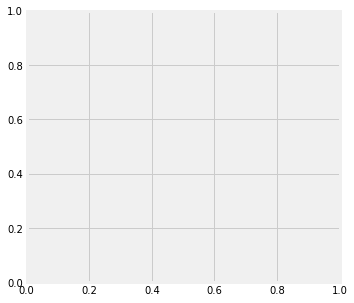

In [10]:
%matplotlib inline

print(icvf_stat(sample))
plot_traj_image(sample, sample['observations'][0], sample['ailot_high_targets'][0], sample['ailot_low_goals'][0], "notebooks/antmaze-large.png")

In [11]:
from tqdm.auto import tqdm
from jaxrl_m.common import TrainStateEQX
from src.agents.iql_equinox import GaussianPolicy, GaussianIntentPolicy

from ott.geometry import pointcloud
from ott.tools import plot, sinkhorn_divergence
from ott.solvers.linear import implicit_differentiation as imp_diff

import optax

def gradient_flow(
    num_iter: int = 5_500,
    batch_size: int = 1024,
):

    key = jax.random.PRNGKey(42)
    actor_intents_learner = TrainStateEQX.create(model=GaussianIntentPolicy(key=key,
                             hidden_dims=[512, 512, 512],
                             state_dim=29,
                             intent_dim=256), optim=optax.adam(learning_rate=1e-3))
    
    def sink_div(agent_policy, batch, key) -> tuple[float, float]:      
        z_dist = eqx.filter_vmap(agent_policy)(batch['observations'])
        z = z_dist.sample(seed=key)
        z_target = eval_ensemble_psi(icvf_model.value_learner.model, batch['ailot_high_targets']).mean(axis=0)
        geom = pointcloud.PointCloud(x=z, y=z_target)
        ot1 = sinkhorn_divergence.sinkhorn_divergence(
            geom,
            x=geom.x,
            y=geom.y,
            epsilon=0.01,
            static_b=True,
            sinkhorn_kwargs={
                "implicit_diff": imp_diff.ImplicitDiff(),
                "use_danskin": True,
                "max_iterations": 1150
            },
        )
        z_waypoint = eval_ensemble_psi(icvf_model.value_learner.model, batch['ailot_low_goals']).mean(axis=0) # v function to weight
        geom2 = pointcloud.PointCloud(x=z, y=z_waypoint)
        ot2 = sinkhorn_divergence.sinkhorn_divergence(
            geom2,
            x=geom2.x,
            y=geom2.y,
            epsilon=0.001,
            static_b=True,
            sinkhorn_kwargs={
                "implicit_diff": imp_diff.ImplicitDiff(),
                "use_danskin": True,
                "max_iterations": 1000
            },
        )
        
        return ot1.divergence + ot2.divergence
        
    cost_fn_vg = eqx.filter_jit(eqx.filter_value_and_grad)(sink_div, has_aux=False)
    
    @eqx.filter_jit
    def make_step(actor_intents_learner, key, sample):
        cost, policy_grads = cost_fn_vg(actor_intents_learner.model, sample, key)
        actor_intents_learner = actor_intents_learner.apply_updates(policy_grads)
        return actor_intents_learner, cost
        
    pbar = tqdm(range(num_iter))
    for i in pbar:
        key, sample_key = jax.random.split(key, 2)
        batch = gc_dataset.sample(batch_size)
        actor_intents_learner, cost = make_step(actor_intents_learner, key=sample_key, sample=batch)
        pbar.set_postfix({"OT loss": cost})
    return actor_intents_learner
    
updated_actor_intents_learner = gradient_flow()


  0%|          | 3/5500 [01:32<46:52:57, 30.70s/it, OT loss=563.834]  


KeyboardInterrupt: 

In [103]:
from tqdm.auto import tqdm
from jaxrl_m.common import TrainStateEQX
from src.agents.iql_equinox import GaussianPolicy, GaussianIntentPolicy
import optax

def update_low_actor(intents_learner, batch_size, iter_num):
    
    key = jax.random.PRNGKey(42)
    actor_learner = TrainStateEQX.create(
            model=GaussianPolicy(key=key,
                                 hidden_dims=[512, 512, 512],
                                 state_dim=env.observation_space.shape[0],
                                 intents_dim=256,
                                 action_dim=env.action_space.shape[0]),
            optim=optax.adam(learning_rate=1e-3)
        )
    def optimize_actor(actor_learner, sample, key):
        cur_goals_z = eqx.filter_vmap(intents_learner.model)(sample['ailot_low_goals']).sample(seed=key)
        target_goal = eqx.filter_vmap(intents_learner.model)(sample['ailot_high_goals']).sample(seed=key)
        v = eval_ensemble_icvf_latent_zz(icvf_model.value_learner.model, sample['observations'], target_goal, target_goal).mean(0) #cur_goals_z
        nv = eval_ensemble_icvf_latent_zz(icvf_model.value_learner.model, sample['next_observations'], target_goal, target_goal).mean(0)
        adv = nv - v
        exp_a = jnp.minimum(jnp.exp(adv * 10.0), 100.0)
        actor_dist = eqx.filter_vmap(actor_learner)(sample['observations'], cur_goals_z)
        log_prob = actor_dist.log_prob(sample['actions'])
        loss = -(exp_a * log_prob).mean()
        return loss, adv.mean()
    
    actor_loss_fn = eqx.filter_jit(eqx.filter_value_and_grad)(optimize_actor, has_aux=True)
    
    @eqx.filter_jit
    def make_step(actor_learner, sample, key):
        (loss, adv), grads = actor_loss_fn(actor_learner.model, sample, key)
        actor_learner = actor_learner.apply_updates(grads)
        return actor_learner, loss, adv
        
    pbar = tqdm(range(iter_num))
    for i in pbar:
        sample = gc_dataset.sample(batch_size)
        key, sample_key = jax.random.split(key, 2)
        actor_learner, loss, adv = make_step(actor_learner, sample, key=sample_key)
        if i % 500 == 0:
            pbar.set_postfix({"Loss": loss, "Adv": adv})
            
    return actor_learner
    
updated_actor = update_low_actor(intents_learner=updated_actor_intents_learner, batch_size=1024, iter_num=50_000)

  0%|          | 0/50000 [00:00<?, ?it/s]

## Resetting ENV

In [110]:
sample = gc_dataset.sample(1)
start_point = d4rl_ds['observations'][1000] ##expert_trajectory[0]
target_goal = expert_trajectory[-8] #sample['ailot_high_goals'][0]
waypoint_goals = expert_trajectory[120] #sample['ailot_low_goals'][0]

env.reset()
env.env.env._wrapped_env.set_xy((start_point[0], start_point[1]))
env.env.env._wrapped_env.set_target((target_goal[0], target_goal[1]))
#print(env.env.env._wrapped_env._get_obs())

Target Goal:  (32.79578939972323, 25.268834904496227)
Target Goal:  (20.58175, 24.036514)


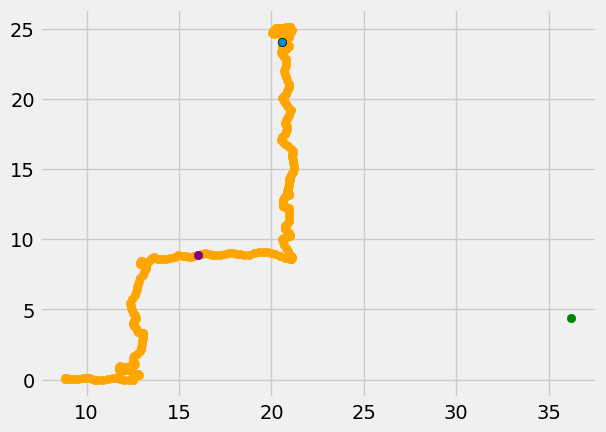

In [111]:
start_point = env.env.env._wrapped_env._get_obs()

plt.scatter(expert_trajectory[:, 0], expert_trajectory[:, 1], alpha=1, label='trajectory', color='orange')
plt.scatter(*env.env.env._wrapped_env.target_goal, label="subgoal", edgecolors='black', alpha=1)
plt.scatter(start_point[0], start_point[1], alpha=1, label='start', color='green')
plt.scatter(waypoint_goals[0], waypoint_goals[1], alpha=1, label='waypoint', color='purple')

In [112]:
key = jax.random.PRNGKey(42)

way_z = eval_ensemble_psi(icvf_model.value_learner.model, waypoint_goals[None]).mean(axis=0)
target_z = eval_ensemble_psi(icvf_model.value_learner.model, target_goal[None]).mean(axis=0)
target_z_pred = updated_actor_intents_learner.model(target_goal).sample(seed=key)
way_z_pred = updated_actor_intents_learner.model(waypoint_goals).sample(seed=key)

In [113]:
eval_ensemble_icvf_latent_zz(icvf_model.value_learner.model, start_point[None], target_z_pred[None], way_z_pred[None])

Array([[-37.151047],
       [-37.151047]], dtype=float32)

In [114]:
os.environ['CUDA_VISIBLE_DEVICES']='4'
env.render(mode='rgb_array')
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'

0.0
V(next_s, g, z)= [-43.32875]
V(s, g, z)= [-42.995758]
Advantage of going to sg from s:  [-0.33299255]


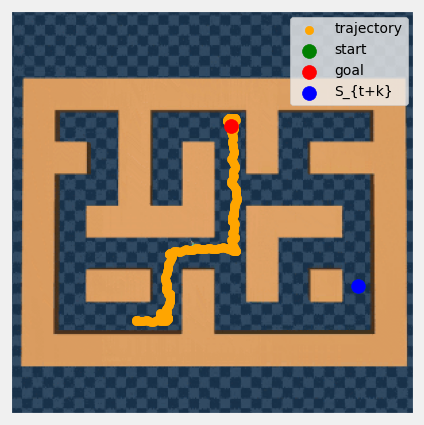

0.0
V(next_s, g, z)= [-40.36377]
V(s, g, z)= [-40.04695]
Advantage of going to sg from s:  [-0.31681824]


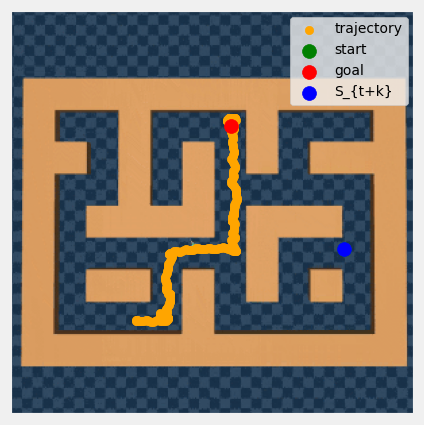

0.0
V(next_s, g, z)= [-40.943718]
V(s, g, z)= [-41.281242]
Advantage of going to sg from s:  [0.3375244]


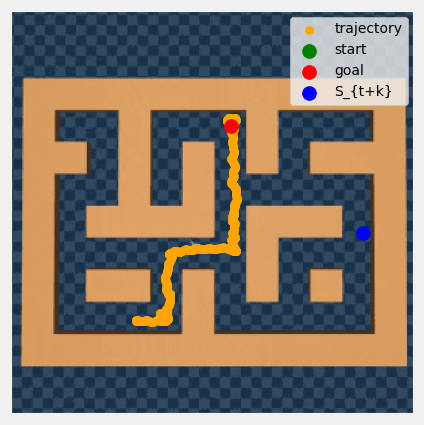

0.0
V(next_s, g, z)= [-44.608658]
V(s, g, z)= [-43.911697]
Advantage of going to sg from s:  [-0.69696045]


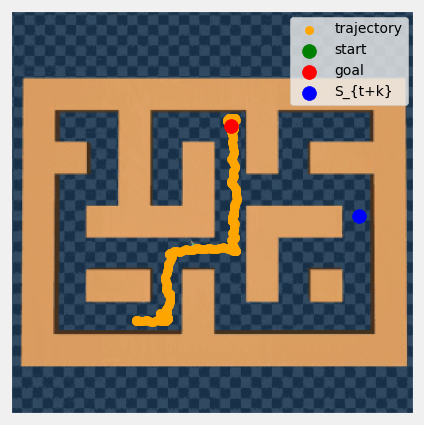

0.0
V(next_s, g, z)= [-44.378227]
V(s, g, z)= [-44.33543]
Advantage of going to sg from s:  [-0.04279709]


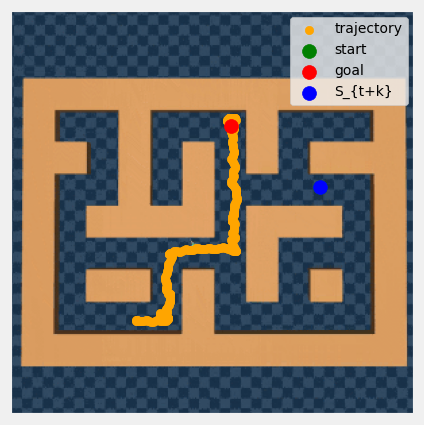

0.0
V(next_s, g, z)= [-46.927673]
V(s, g, z)= [-46.670242]
Advantage of going to sg from s:  [-0.25743103]


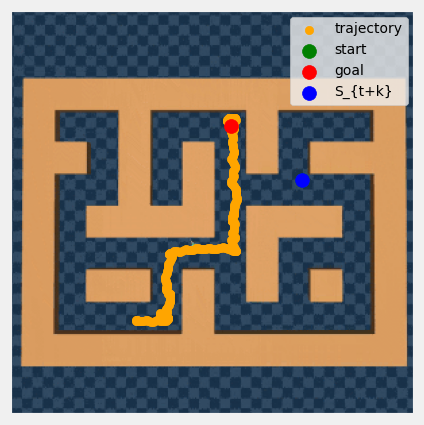

0.0
V(next_s, g, z)= [-50.080715]
V(s, g, z)= [-50.105118]
Advantage of going to sg from s:  [0.02440262]


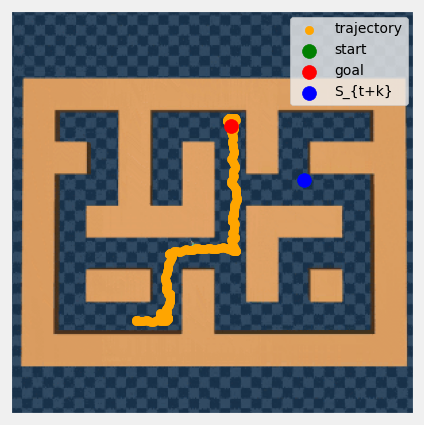

0.0
V(next_s, g, z)= [-43.737312]
V(s, g, z)= [-43.683044]
Advantage of going to sg from s:  [-0.05426788]


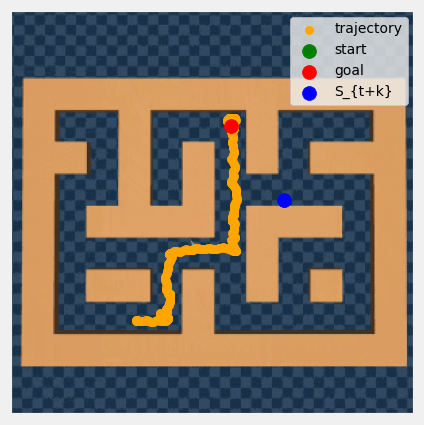

0.0
V(next_s, g, z)= [-37.771416]
V(s, g, z)= [-37.790405]
Advantage of going to sg from s:  [0.01898956]


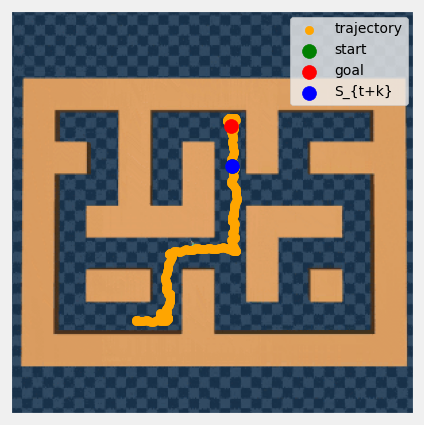

1.0
V(next_s, g, z)= [-34.459045]
V(s, g, z)= [-34.725216]
Advantage of going to sg from s:  [0.2661705]


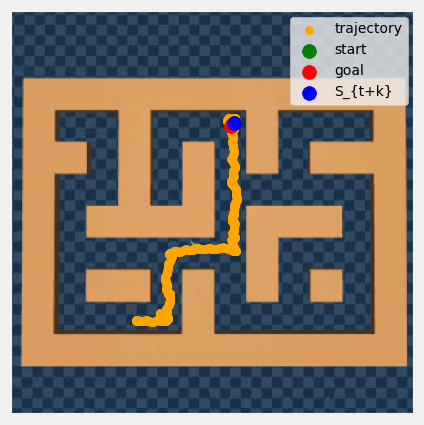

Moviepy - Building video /home/m_bobrin/AILOT/rl-video-episode-0.mp4.
Moviepy - Writing video /home/m_bobrin/AILOT/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/m_bobrin/AILOT/rl-video-episode-0.mp4


In [115]:
from gymnasium.utils import save_video

sample_key = jax.random.PRNGKey(42)
curr_point = start_point
frames=[]
env.env.env._wrapped_env.viewer.cam.lookat[0] = 18
env.env.env._wrapped_env.viewer.cam.lookat[1] = 12
env.env.env._wrapped_env.viewer.cam.distance = 50
env.env.env._wrapped_env.viewer.cam.elevation = -90

i = 0
done = False
while not done:
    key, sample_key = jax.random.split(sample_key, 2)
    intent = updated_actor_intents_learner.model(curr_point).sample(seed=key)
    action = jax.device_get(updated_actor.model(curr_point.squeeze(), intent.squeeze()).sample(seed=key))
    action = jnp.clip(action, -1, 1)
    new_obs, reward, done ,_ = env.step(action)
    
    os.environ['CUDA_VISIBLE_DEVICES']='4'
    frames.append(env.render(mode='rgb_array'))
    os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'
    
    if i % 100 == 0:
        print(reward)
        Vnsgz = eval_ensemble_icvf_latent_z(icvf_model.value_learner.model, curr_point[None], target_goal[None], intent[None]).mean(0)
        Vsgz = eval_ensemble_icvf_latent_z(icvf_model.value_learner.model, new_obs[None], target_goal[None], intent[None]).mean(0)
        print("V(next_s, g, z)=", Vnsgz)
        print("V(s, g, z)=", Vsgz)
        print("Advantage of going to sg from s: ", Vnsgz - Vsgz)
        
        plot_traj_image(sample, new_obs, target_goal, new_obs, "notebooks/antmaze-large.png")
        plt.show()
    curr_point = new_obs
    i+=1
save_video.save_video(frames, video_folder='.', fps=env.env.env._wrapped_env.metadata['render_fps'])

### CartPole

In [6]:
from src.agents import icvf
%cd ..
cartpole_env = gym.make('CartPole-v1')
icvf_model = icvf.create_eqx_learner(seed=42,
                                     observations=cartpole_env.observation_space,
                                     hidden_dims=[256, 256],
                                     pretrained_folder='cartpole-v1',
                                     load_pretrained_icvf=True)


/home/m_bobrin/AILOT
Extra kwargs: {}


How to get dataset? 

### XMagical Cross-Domain ENV

In [ ]:
def update_low_actor(state, target_goal):
    
    key = jax.random.PRNGKey(42)
    actor_learner = TrainStateEQX.create(
            model=GaussianPolicy(key=key,
                                 hidden_dims=[256, 256, 256],
                                 state_dim=env.observation_space.shape[0],
                                 intents_dim=256,
                                 action_dim=env.action_space.shape[0]),
            optim=optax.adam(learning_rate=1e-3)
        )
    z_target = eval_ensemble_psi(icvf_model.value_learner.model, target_goal[None]).mean(axis=0)
    all_states = jnp.asarray(d4rl_ds['observations'])
    maxval = all_states.shape[0]-1
        
    def optimize_actor(actor_learner, state, next_state, action, sample_key):
        intents = z_target
        intents = jnp.tile(intents, reps=(state.shape[0], 1))
        #intents = jax.lax.stop_gradient(eqx.filter_vmap(actor_intent_learner.model)(state).sample(seed=sample_key))
        
        v = eval_ensemble_icvf_latent_zz(icvf_model.value_learner.model, state, intents, intents).mean(0)
        nv = eval_ensemble_icvf_latent_zz(icvf_model.value_learner.model, next_state, intents, intents).mean(0)
        adv = nv - v
        exp_a = jnp.minimum(jnp.exp(adv * 5.0), 100.0)
        exp_a = jax.lax.stop_gradient(exp_a)
        actor_dist = eqx.filter_vmap(actor_learner)(state, intents)
        log_prob = actor_dist.log_prob(action)
        loss = -(exp_a * log_prob).mean()
        return loss, adv.mean()

    def make_step():
        rand_num = jax.random.randint(key=sample_key, shape=(512, ), minval=0, maxval=maxval)
        state = d4rl_ds['observations'][rand_num]
        next_state = d4rl_ds['observations'][rand_num + 1]
        action = d4rl_ds['actions'][rand_num]
        (loss, adv), grads = actor_loss_fn(actor_learner.model, state, next_state, action, sample_key)
        actor_learner = actor_learner.apply_updates(grads)
        return actor_learner, loss, adv
    
    actor_loss_fn = eqx.filter_jit(eqx.filter_value_and_grad)(optimize_actor, has_aux=True)
    
    for i in tqdm(range(10_000)):
        key, sample_key = jax.random.split(key, 2)
        actor_learner, loss, adv = make_step(actor_learner)
        
        if i % 200 == 0:
            print(loss, adv)
            
    return actor_learner
    
updated_actor = update_low_actor(start_point, target_subgoal)

### PointMaze

In [100]:
def get_starting_boundary(env):
    S = env.env.env
    return (0, 0), (S.maze_arr.shape[0], S.maze_arr.shape[1])

def XY(env, n=10):
    bl, tr = get_starting_boundary(env)
    X = np.linspace(bl[0] + 0.04 * (tr[0] - bl[0]) , tr[0] - 0.04 * (tr[0] - bl[0]), n)
    Y = np.linspace(bl[1] + 0.04 * (tr[1] - bl[1]) , tr[1] - 0.04 * (tr[1] - bl[1]), n)
    
    X,Y = np.meshgrid(X,Y)
    states = np.array([X.flatten(), Y.flatten()]).T
    return states
    
def generate_maze_img(ax, fig, state_list, n=50, icvf_values=None):
    S = 1.0
    torso_x = 0.0
    torso_y = 0.0
    points = XY(env, n=n)
    whole_grid = state_list[-1]
    print(whole_grid)
    whole_grid = np.tile(whole_grid, (points.shape[0], 1))
    whole_grid[:, :2] = points
    
    if icvf_values is None:
        Z = np.random.rand(n, n)
    else:
        Z = get_v_zz_heatmap(icvf_model, whole_grid, state_list).mean(0)
    im = ax.pcolormesh(points[:,0].reshape(n, n), points[:, 1].reshape(n, n), Z.reshape(n, n), edgecolor='black', shading='nearest')
    
    for i in range(len(env.env.env.maze_arr)):
        for j in range(len(env.env.env.maze_arr[0])):
            struct = env.env.env.maze_arr[i][j]
            if struct == 10:
                rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                        i * S- torso_y - S/ 2),
                                        S,
                                        S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
                ax.add_patch(rect)
    ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env.maze_arr) * S - torso_x - S/2 - S * 0.6)
    ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env.maze_arr[0]) * S - torso_y - S/2 - S * 0.6)
    fig.colorbar(im)
    return ax

In [108]:
env = gym.make("maze2d-large-dense-v1")
d4rl_pm = d4rl.qlearning_dataset(env)

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


[ 7.7516546   8.956252   -3.7094433   0.12563017]


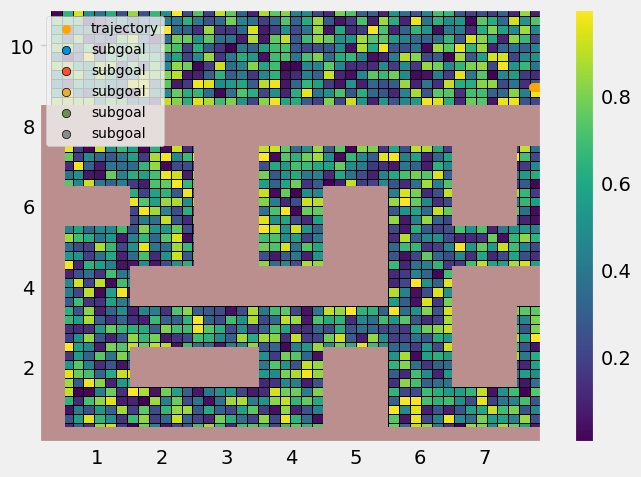

In [109]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(7, 5))

state_list = h5py.File("/home/m_bobrin/datasets/maze/batch_1/rollout_0.h5", 'r')['traj0']['states']
generate_maze_img(ax, fig, state_list)

SUBGOALS = state_list[[0, 30, 85, 150, 189]]
plt.scatter(state_list[:, 0], state_list[:, 1], alpha=1, label='trajectory', color='orange')
for i in range(SUBGOALS.shape[0]):
    plt.scatter(*SUBGOALS[i, :2], label="subgoal", edgecolors='black', alpha=1)
    
plt.legend(loc='upper left', fontsize=10)
fig.tight_layout()


In [4]:
env = gym.make("antmaze-large-diverse-v2")
d4rl_ds = d4rl.qlearning_dataset(env)

Target Goal:  (32.97756252476421, 24.903303970009457)


load datafile: 100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.35it/s]


In [5]:
# https://github.com/Farama-Foundation/D4RL/blob/master/d4rl/locomotion/maze_env.py
#env.env.env._wrapped_env??

env.env.env._wrapped_env._maze_map

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 'r', 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
 [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
 [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
 [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
 [1, 0, 0, 1, 0, 0, 0, 1, 0, 'g', 0, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

In [6]:
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        if env.env.env._wrapped_env._maze_map[i][j] in ['r', 'g']:
            env.env.env._wrapped_env._maze_map[i][j] = 0

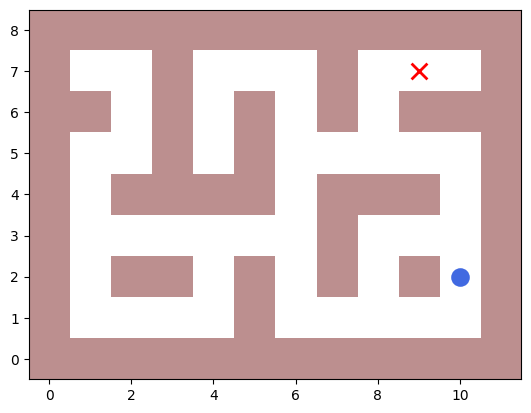

In [7]:
import numpy as np
plt.imshow(1 - np.array(env.env.env._wrapped_env._maze_map), cmap=cmap, origin="lower")
plt.scatter(*env.env.env._wrapped_env._xy_to_rowcol((33.12297854530087, 24.974616400316876))[::-1], marker="x", c='red', s=130, linewidths=2)
plt.scatter(*env.env.env._wrapped_env._xy_to_rowcol((36.376736 ,  5.238806))[::-1], marker="o", c='royalblue', s=130, linewidths=2)

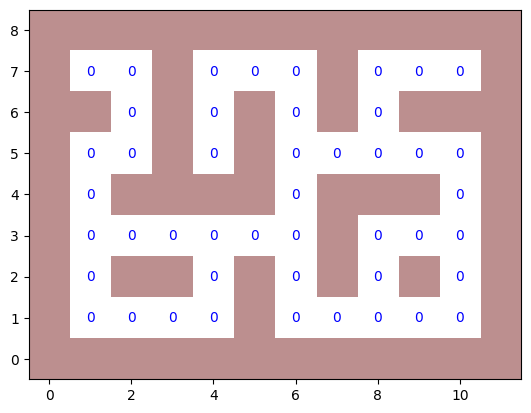

In [8]:
plt.imshow(1 - np.array(env.env.env._wrapped_env._maze_map), cmap=cmap, origin="lower")
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        if np.array(env.env.env._wrapped_env._maze_map)[i, j] != 1:
            text = plt.text(j, i, np.array(env.env.env._wrapped_env._maze_map)[i, j],
                           ha="center", va="center", color="b")

In [44]:
xy = d4rl_ds['observations'][np.arange(2000, 2050)][:, :2]

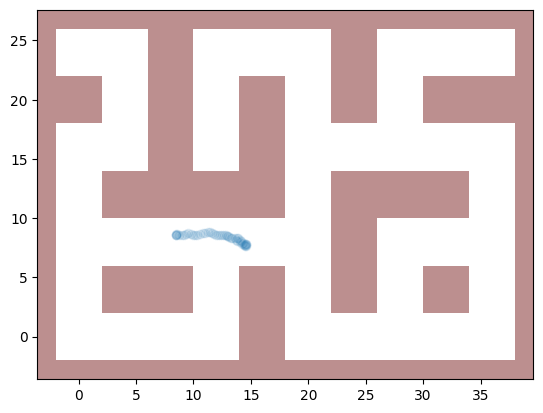

In [46]:
from matplotlib import patches

ax = plt.gca()
torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
S =  env.env.env._wrapped_env._maze_size_scaling
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        struct = env.env.env._wrapped_env._maze_map[i][j]
        if struct == 1:
            rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                    i * S- torso_y - S/ 2),
                                    S,
                                    S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
            ax.add_patch(rect)
ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env._wrapped_env._maze_map[0]) * S - torso_x - S/2 - S * 0.6)
ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env._wrapped_env._maze_map) * S - torso_y - S/2 - S * 0.6)
plt.scatter(xy[:, 0], xy[:, 1], alpha=0.1)

In [16]:
wrapped_env = env.env.env._wrapped_env
torso_x, torso_y = wrapped_env._init_torso_x, wrapped_env._init_torso_y
S = wrapped_env._maze_size_scaling
print((0 - S / 2 + S - torso_x, 0 - S/2 + S - torso_y), (len(wrapped_env._maze_map[0]) * S - torso_x - S/2 - S, len(wrapped_env._maze_map) * S - torso_y - S/2 - S))

def XY(n=20):
    bl, tr = (-2.0, -2.0), (38.0, 26.0)
    X = np.linspace(bl[0] + 0.04 * (tr[0] - bl[0]) , tr[0] - 0.04 * (tr[0] - bl[0]), n)
    Y = np.linspace(bl[1] + 0.04 * (tr[1] - bl[1]) , tr[1] - 0.04 * (tr[1] - bl[1]), n)
    
    X,Y = np.meshgrid(X,Y)
    states = np.array([X.flatten(), Y.flatten()]).T
    return states

(-2.0, -2.0) (38.0, 26.0)


In [23]:
obs = XY()

## AntMaze-Umaze

In [3]:
env = gym.make("antmaze-umaze-v2")
d4rl_ds = d4rl.qlearning_dataset(env)

Target Goal:  (0.7241989442597729, 8.374488737841759)


load datafile: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.36it/s]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

xy = d4rl_ds['observations'][np.arange(700, 800)][:, :2]

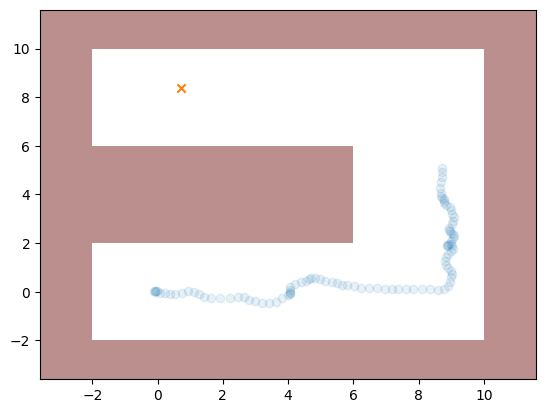

In [9]:
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        if env.env.env._wrapped_env._maze_map[i][j] in ['r', 'g']:
            env.env.env._wrapped_env._maze_map[i][j] = 0

from matplotlib import patches

ax = plt.gca()
torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
S =  env.env.env._wrapped_env._maze_size_scaling
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        struct = env.env.env._wrapped_env._maze_map[i][j]
        if struct == 1:
            rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                    i * S- torso_y - S/ 2),
                                    S,
                                    S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
            ax.add_patch(rect)
ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env._wrapped_env._maze_map[0]) * S - torso_x - S/2 - S * 0.6)
ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env._wrapped_env._maze_map) * S - torso_y - S/2 - S * 0.6)
plt.scatter(xy[:, 0], xy[:, 1], alpha=0.1)
plt.scatter(*env.env.env._wrapped_env.target_goal, marker="x")

In [5]:
dones_float = np.zeros_like(d4rl_ds['rewards'])

for i in range(len(dones_float) - 1):
    if np.linalg.norm(d4rl_ds['observations'][i + 1] - d4rl_ds['next_observations'][i]) > 1e-6:
        dones_float[i] = 1
    else:
        dones_float[i] = 0
dones_float[-1] = 1

In [6]:
np.nonzero(dones_float)[0][:300]

array([   699,   1399,   2099,   2799,   3499,   4199,   4899,   5599,
         6299,   6999,   7699,   8399,   9099,   9799,  10499,  11199,
        11899,  12599,  13299,  13999,  14699,  15399,  16099,  16799,
        17499,  18199,  18899,  19599,  20299,  20999,  21699,  22399,
        23099,  23799,  24499,  25199,  25899,  26599,  27299,  27999,
        28699,  29399,  30099,  30799,  31499,  32199,  32899,  33599,
        34299,  34999,  35699,  36399,  37099,  37799,  38499,  39199,
        39899,  40599,  41299,  41999,  42699,  43399,  44099,  44799,
        45499,  46199,  46899,  47599,  48299,  48999,  49699,  50399,
        51099,  51799,  52499,  53199,  53899,  54599,  55299,  55999,
        56699,  57399,  58099,  58799,  59499,  60199,  60899,  61599,
        62299,  62999,  63699,  64399,  65099,  65799,  66499,  67199,
        67899,  68599,  69299,  69999,  70699,  71399,  72099,  72799,
        73499,  74199,  74899,  75599,  76299,  76999,  77699,  78399,
      

In [3]:
env = gym.make("antmaze-umaze-diverse-v2")
d4rl_ds = d4rl.qlearning_dataset(env)

Target Goal:  (1.236760811266488, 8.374969640435834)


load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.33it/s]


In [7]:
import h5py
from tqdm.auto import tqdm

def get_keys(h5file):
    keys = []

    def visitor(name, item):
        if isinstance(item, h5py.Dataset):
            keys.append(name)

    h5file.visititems(visitor)
    return keys

def get_dataset(h5path):
    data_dict = {}
    with h5py.File(h5path, 'r') as dataset_file:
        for k in tqdm(get_keys(dataset_file), desc="load datafile"):
            try:  # first try loading as an array
                data_dict[k] = dataset_file[k][:]
            except ValueError as e:  # try loading as a scalar
                data_dict[k] = dataset_file[k][()]

    return data_dict
    
random_agent_ds = get_dataset("/home/m_bobrin/AILOT/antmaze-umaze-v2-noiserandomaction.hdf5")

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.29it/s]


In [78]:
xy = combined['observations'][np.arange(203000, 204000)][:, :2]

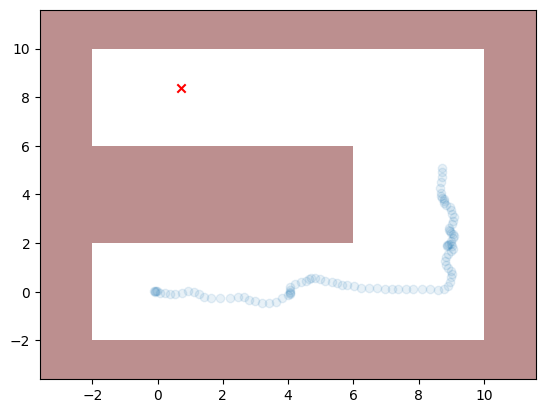

In [12]:
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        if env.env.env._wrapped_env._maze_map[i][j] in ['r', 'g']:
            env.env.env._wrapped_env._maze_map[i][j] = 0

from matplotlib import patches

ax = plt.gca()
torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
S =  env.env.env._wrapped_env._maze_size_scaling
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        struct = env.env.env._wrapped_env._maze_map[i][j]
        if struct == 1:
            rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                    i * S- torso_y - S/ 2),
                                    S,
                                    S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
            ax.add_patch(rect)
ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env._wrapped_env._maze_map[0]) * S - torso_x - S/2 - S * 0.6)
ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env._wrapped_env._maze_map) * S - torso_y - S/2 - S * 0.6)
plt.scatter(xy[:, 0], xy[:, 1], alpha=0.1)
plt.scatter(*env.env.env._wrapped_env.target_goal, marker="x", c='red')

In [17]:
def combine_ds(expert_ds, agent_ds):
    expert_timeouts = np.nonzero(dones_float)[0] #np.nonzero(expert_ds['dones_float'])[0] # Timeouts = Not neccesarly achived target goal & received reward
    agent_timeouts = np.nonzero(agent_ds['timeouts'])[0]
    num_expert_trajectories = 500 # each trajectory of size 1k; timeout on each of 700 steps, thus 700 * 500=350k
    num_agent_trajectories = 200
    expert_slice = 700 * num_expert_trajectories
    agent_slice = 1000*num_agent_trajectories

    print(agent_timeouts[:num_agent_trajectories])
    mixed_ds = {
        'observations': np.concatenate((agent_ds['observations'][:agent_slice], expert_ds['observations'][:expert_slice])),
        'next_observations': np.concatenate((agent_ds['next_observations'][:agent_slice], expert_ds['next_observations'][:expert_slice])),
        'rewards': np.concatenate((agent_ds['rewards'][:agent_slice], expert_ds['rewards'][:expert_slice])),
        'actions': np.concatenate((agent_ds['actions'][:agent_slice], expert_ds['actions'][:expert_slice])),
        'terminals': np.concatenate((agent_ds['terminals'][:agent_slice], expert_ds['terminals'][:expert_slice])),
        'dones_float': np.concatenate((agent_timeouts[:num_agent_trajectories], expert_timeouts[:num_expert_trajectories]))
    }
    return mixed_ds
    
combined = combine_ds(d4rl_ds, random_agent_ds)

[  1000   2001   3002   4003   5004   6005   7006   8007   9008  10009
  11010  12011  13012  14013  15014  16015  17016  18017  19018  20019
  21020  22021  23022  24023  25024  26025  27026  28027  29028  30029
  31030  32031  33032  34033  35034  36035  37036  38037  39038  40039
  41040  42041  43042  44043  45044  46045  47046  48047  49048  50049
  51050  52051  53052  54053  55054  56055  57056  58057  59058  60059
  61060  62061  63062  64063  65064  66065  67066  68067  69068  70069
  71070  72071  73072  74073  75074  76075  77076  78077  79078  80079
  81080  82081  83082  84083  85084  86085  87086  88087  89088  90089
  91090  92091  93092  94093  95094  96095  97096  98097  99098 100099
 101100 102101 103102 104103 105104 106105 107106 108107 109108 110109
 111110 112111 113112 114113 115114 116115 117116 118117 119118 120119
 121120 122121 123122 124123 125124 126125 127126 128127 129128 130129
 131130 132131 133132 134133 135134 136135 137136 138137 139138 140139
 14114

In [18]:
combined['dones_float']

array([  1000,   2001,   3002,   4003,   5004,   6005,   7006,   8007,
         9008,  10009,  11010,  12011,  13012,  14013,  15014,  16015,
        17016,  18017,  19018,  20019,  21020,  22021,  23022,  24023,
        25024,  26025,  27026,  28027,  29028,  30029,  31030,  32031,
        33032,  34033,  35034,  36035,  37036,  38037,  39038,  40039,
        41040,  42041,  43042,  44043,  45044,  46045,  47046,  48047,
        49048,  50049,  51050,  52051,  53052,  54053,  55054,  56055,
        57056,  58057,  59058,  60059,  61060,  62061,  63062,  64063,
        65064,  66065,  67066,  68067,  69068,  70069,  71070,  72071,
        73072,  74073,  75074,  76075,  77076,  78077,  79078,  80079,
        81080,  82081,  83082,  84083,  85084,  86085,  87086,  88087,
        89088,  90089,  91090,  92091,  93092,  94093,  95094,  96095,
        97096,  98097,  99098, 100099, 101100, 102101, 103102, 104103,
       105104, 106105, 107106, 108107, 109108, 110109, 111110, 112111,
      